In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
df_desc = pd.read_excel('../data/momentum_data.xlsx', sheet_name='descriptions')
df_factors = pd.read_excel('../data/momentum_data.xlsx', sheet_name='factors (excess returns)').set_index('Date')
df_momentum = pd.read_excel('../data/momentum_data.xlsx', sheet_name='momentum (excess returns)').set_index('Date')
df_deciles = pd.read_excel('../data/momentum_data.xlsx', sheet_name='deciles (total returns)').set_index('Date')
df_size_sorts = pd.read_excel('../data/momentum_data.xlsx', sheet_name='size_sorts (total returns)').set_index('Date')
df_rfr = pd.read_excel('../data/momentum_data.xlsx', sheet_name='risk-free rate').set_index('Date')

In [3]:
# 2
df_factors['UMD'] = df_momentum
df_factors.tail()

,MKT,SMB,HML,UMD
Date,,,,
2024-05-31,0.0434,0.0078,-0.0166,-0.0002
2024-06-30,0.0277,-0.0306,-0.0331,0.0090
2024-07-31,0.0124,0.0680,0.0573,-0.0242
2024-08-31,0.0161,-0.0355,-0.0113,0.0479
2024-09-30,0.0174,-0.0017,-0.0260,-0.0061


In [4]:
df_momentum.tail()

,UMD
Date,
2024-05-31,-0.0002
2024-06-30,0.0090
2024-07-31,-0.0242
2024-08-31,0.0479
2024-09-30,-0.0061


In [5]:
df_deciles.head()

,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR
Date,,,,,,,,,,
1927-01-31,-0.0332,-0.0446,0.0269,-0.0033,-0.0041,0.0097,0.0074,0.0036,-0.0041,-0.0024
1927-02-28,0.0753,0.0593,0.0825,0.0727,0.0322,0.0421,0.0283,0.0326,0.0420,0.0701
1927-03-31,-0.0323,-0.0301,-0.0392,-0.0477,-0.0048,-0.0242,0.0205,0.0041,0.0096,0.0547
1927-04-30,0.0204,-0.0320,-0.0247,-0.0137,0.0220,-0.0005,0.0205,-0.0059,0.0159,0.0549
1927-05-31,0.0272,0.0457,0.0595,0.0318,0.0636,0.0580,0.0496,0.0681,0.0811,0.0632


In [6]:
df_size_sorts.head()

,SMALL LoPRIOR,ME1 PRIOR2,SMALL HiPRIOR,BIG LoPRIOR,ME2 PRIOR2,BIG HiPRIOR
Date,,,,,,
1927-01-31,0.0008,0.0357,0.0040,-0.0040,0.0026,0.0000
1927-02-28,0.0701,0.0648,0.0551,0.0727,0.0380,0.0447
1927-03-31,-0.0346,-0.0288,-0.0206,-0.0357,-0.0018,0.0226
1927-04-30,-0.0075,-0.0048,0.0332,-0.0272,0.0075,0.0181
1927-05-31,0.0248,0.1115,0.0683,0.0552,0.0496,0.0718


In [7]:
df_rfr.head()

,RF
Date,
1927-01-31,0.0025
1927-02-28,0.0026
1927-03-31,0.0030
1927-04-30,0.0025
1927-05-31,0.0030


In [8]:
# 2.1
def calculate_univariate_performance_statistics(df, annualization_factor=1, quantile=0.05, periods=None):
    if periods is None:
        periods = [(df.index.min(), df.index.max())]
    
    summary_list = []

    for period in periods:
        start_date, end_date = period
        period_df = df.loc[start_date:end_date]
        
        summary_df = pd.DataFrame(index=period_df.columns)
        summary_df['mean'] = period_df.mean() * annualization_factor
        summary_df['vol'] = period_df.std() * (annualization_factor ** 0.5)
        summary_df['sharpe'] = summary_df['mean'] / summary_df['vol']
        summary_df['sharpe'] = summary_df['mean'] / summary_df['vol']
        summary_df['skewness'] =  period_df.skew()
        summary_df['corr to market'] =  df_factors.loc[start_date:end_date:].corr().loc['MKT',['UMD']]
        summary_df['corr to val'] =  df_factors.loc[start_date:end_date:].corr().loc['HML',['UMD']]
        start_year = pd.to_datetime(start_date).year
        end_year = pd.to_datetime(end_date).year
        summary_df['Period'] = f"{start_year}-{end_year}"
        summary_df = summary_df.reset_index().rename(columns={'index': 'Factor'}).set_index(['Period', 'Factor'])
        summary_list.append(summary_df)
    
    summary = pd.concat(summary_list)
    return summary

periods = [(df_momentum.index.min(), df_momentum.index.max()), ('1927-01-01', '1993-12-31'), ('1994-01-01', '2008-12-31'), ('2009-01-01', df_momentum.index.max())]
summary_statistics = calculate_univariate_performance_statistics(df_momentum, 12, periods=periods)
summary_statistics

,,mean,vol,sharpe,skewness,corr to market,corr to val
Period,Factor,,,,,,
1927-2024,UMD,0.075328,0.162508,0.463534,-2.990493,-0.344284,-0.406410
1927-1993,UMD,0.090081,0.160003,0.562992,-3.808207,-0.362496,-0.495002
1994-2008,UMD,0.104373,0.175551,0.594548,-0.582038,-0.234519,-0.129361
2009-2024,UMD,-0.015092,0.158467,-0.095238,-2.691022,-0.367588,-0.320924


#### 2.1.b
- The mean returns for momentum have decreased significantly over time, especially in the most recent period (2009–2024), suggesting that profitability has diminished post-2008.

- Volatility remains fairly stable. Sharpe ratios have declined, particularly in the 2009-2024 period, where they even turned negative. This indicates lower risk-adjusted returns in recent years.

- Momentum returns exhibit significant negative skewness across periods, which implies occasional large negative returns—a potential risk for momentum investors.

- Negative correlations with the market remain across all periods, with a slight increase in the most recent years. Momentum still provides some level of diversification relative to the broader market.

- Momentum has a negative correlation with value, remaining a potential diversification asset against value-focused investments, though this has lessened since 1994.


#### 2.1.c
- Momentum was profitable in 2008 when AQR was planning its launch.
- With low correlation to both market and value factors, momentum offers strong diversification benefits.
- Even if mean returns approach zero, momentum remains valuable due to its low correlation with other factors.

In [9]:
# 2.2
df_mom = pd.DataFrame(index=df_momentum.index)
df_mom['long-only'] = (df_size_sorts['BIG HiPRIOR'] + df_size_sorts['SMALL HiPRIOR'])/2 - df_rfr['RF']
df_mom['long-and-short'] = df_momentum
df_factors_copy = df_factors.copy().rename(columns={'UMD':'long_and_short'})
df_factors_copy['long_only'] = (df_size_sorts['BIG HiPRIOR'] + df_size_sorts['SMALL HiPRIOR'])/2 - df_rfr['RF']
periods = [(df_momentum.index.min(), df_momentum.index.max())]
summary_statistics = calculate_univariate_performance_statistics(df_mom, 12, periods=periods)
summary_statistics['corr to market'] = [df_factors_copy.corr()['MKT']['long_only'], df_factors_copy.corr()['MKT']['long_and_short']]
summary_statistics['corr to val'] = [df_factors_copy.corr()['HML']['long_only'], df_factors_copy.corr()['HML']['long_and_short']]
summary_statistics

mean       vol    sharpe  skewness  \
Period    Factor                                                   
1927-2024 long-only       0.135382  0.212464  0.637199 -0.015827   
          long-and-short  0.075328  0.162508  0.463534 -2.990493   

                          corr to market  corr to val  
Period    Factor                                       
1927-2024 long-only             0.935817     0.210531  
          long-and-short       -0.344284    -0.406410

#### 2.2.b
- The long-only strategy has a higher mean return (0.135) than the long-and-short strategy (0.075), indicating a potential return advantage.

- Volatility is higher for the long-only strategy (0.212) than for the long-and-short (0.163), suggesting higher risk in the long-only approach.

- Despite the higher return, the Sharpe ratio for long-only (0.637) is higher than that of long-and-short (0.464), indicating better risk-adjusted performance.

- The long-and-short strategy has highly negative skewness (-2.99), signaling extreme negative returns occasionally, while long-only is relatively neutral (-0.016).

- Long-only is highly correlated with the market (0.936), losing some diversification benefits, whereas long-and-short maintains a negative correlation (-0.344), offering better diversification.

- Long-only has a positive correlation with value (0.211), while long-and-short shows negative correlation (-0.406), enhancing its diversification across factors.

#### 2.2.c
- No, the long-only momentum portfolio shows a high correlation with the market at 93.58%, while the long-short momentum portfolio maintains a negative correlation of -34%.

- This difference arises because the long-only portfolio remains exposed to market risk, reducing its effectiveness as a diversifier.

<Axes: xlabel='Date'>

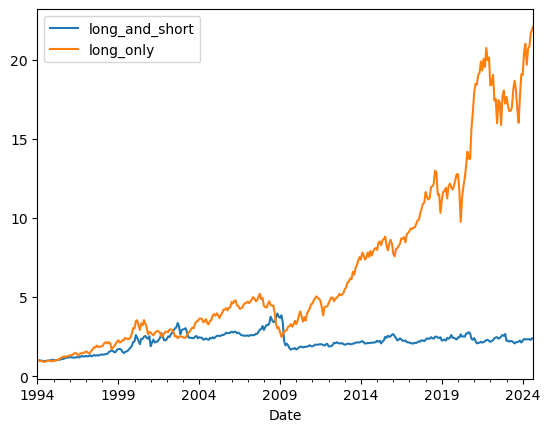

In [10]:
# 2.2.d
(1+df_factors_copy[['long_and_short', 'long_only']].loc['1994-01-01':]).cumprod().plot()

In [11]:
# 2.3.a
df_mom_decile = pd.DataFrame(index = df_momentum.index)
df_mom_decile['momD1'] = df_deciles['Hi PRIOR'] - df_deciles['Lo PRIOR']
df_mom_decile['momD3'] = df_deciles.iloc[:,-3:].mean(axis = 1) - df_deciles.iloc[:,:3].mean(axis = 1)
df_mom_decile['momD5'] = df_deciles.iloc[:,-5:].mean(axis = 1) - df_deciles.iloc[:,:5].mean(axis = 1)
summary_statistics = calculate_univariate_performance_statistics(df_mom_decile, 12, periods=periods)
df_factors_copy = df_factors.copy()
df_factors_copy['momD1'] = df_mom_decile['momD1']
df_factors_copy['momD3'] = df_mom_decile['momD3']
df_factors_copy['momD5'] = df_mom_decile['momD5']
summary_statistics['corr to market'] = [df_factors_copy.corr()['MKT']['momD1'], df_factors_copy.corr()['MKT']['momD3'], df_factors_copy.corr()['MKT']['momD5']]
summary_statistics['corr to val'] = [df_factors_copy.corr()['HML']['momD1'], df_factors_copy.corr()['HML']['momD3'], df_factors_copy.corr()['HML']['momD5']]
summary_statistics

mean       vol    sharpe  skewness  corr to market  \
Period    Factor                                                           
1927-2024 momD1   0.137789  0.273979  0.502920 -2.221209       -0.369000   
          momD3   0.075686  0.190025  0.398293 -2.511962       -0.381904   
          momD5   0.050059  0.133536  0.374869 -2.495177       -0.361677   

                  corr to val  
Period    Factor               
1927-2024 momD1     -0.404373  
          momD3     -0.396644  
          momD5     -0.391819

#### 2.3.b 
- Yes, a long-short portfolio with a higher decile threshold does indeed show higher returns, as seen in momD1 (0.138) compared to momD3 (0.076) and momD5 (0.050).

- This also comes with increased volatility, as momD1 has the highest volatility (0.274), followed by momD3 (0.190) and momD5 (0.134).

- This tradeoff aligns with expectations: higher return potential comes with higher risk.

#### 2.3.c
- I would recommend the 1-decile (momD1) construction, as it offers the highest Sharpe ratio (0.503), indicating better risk-adjusted returns compared to the 3-decile (momD3) and 5-decile (momD5) constructions.

- momD1 captures the highest returns, which may be more attractive for an AQR retail product aiming for strong performance.

#### 2.3.d
- The Fama-French construction and the top 3 deciles (momD3) are similar in structure, but Fama-French achieves a higher return and lower volatility, leading to a higher Sharpe ratio.

- Fama-French construction achieves balance by incorporating both small and large stocks, reducing potential bias, whereas the top 3 deciles construction may be more susceptible to size bias if one size category dominates.

- This balanced approach in the Fama-French construction enhances its stability and risk-adjusted performance, making it a robust choice.

In [12]:
# 2.4.a
df_mom_size = pd.DataFrame(index = df_momentum.index)
df_mom_size['Small Stocks'] = df_size_sorts['SMALL HiPRIOR'] - df_size_sorts['SMALL LoPRIOR']
df_mom_size['Big Stocks'] = df_size_sorts['BIG HiPRIOR'] - df_size_sorts['BIG LoPRIOR']
df_mom_size['All Stocks'] = df_momentum['UMD']
summary_statistics = calculate_univariate_performance_statistics(df_mom_size, 12, periods=periods)
df_factors_copy = df_factors.copy()
df_factors_copy['Small Stocks'] = df_mom_size['Small Stocks']
df_factors_copy['Big Stocks'] = df_mom_size['Big Stocks']
df_factors_copy['All Stocks'] = df_mom_size['All Stocks']
summary_statistics['corr to market'] = [df_factors_copy.corr()['MKT']['Small Stocks'], df_factors_copy.corr()['MKT']['Big Stocks'], df_factors_copy.corr()['MKT']['All Stocks']]
summary_statistics['corr to val'] = [df_factors_copy.corr()['HML']['Small Stocks'], df_factors_copy.corr()['HML']['Big Stocks'], df_factors_copy.corr()['HML']['All Stocks']]
summary_statistics

mean       vol    sharpe  skewness  \
Period    Factor                                                 
1927-2024 Small Stocks  0.090731  0.161533  0.561691 -3.087126   
          Big Stocks    0.059877  0.179551  0.333483 -2.290337   
          All Stocks    0.075328  0.162508  0.463534 -2.990493   

                        corr to market  corr to val  
Period    Factor                                     
1927-2024 Small Stocks       -0.331534    -0.388244  
          Big Stocks         -0.324900    -0.386341  
          All Stocks         -0.344284    -0.406410

#### 2.4.b
- Yes, the small-stock momentum portfolio shows nearly three times the Sharpe ratio of the large-stock portfolio (0.562 vs. 0.333), indicating better risk-adjusted returns.

- The large-stock momentum portfolio still provides a positive excess return, making it a viable option despite the lower Sharpe ratio.

- This suggests that while small stocks may drive momentum strategy attractiveness, large stocks can still contribute positively, albeit with less efficiency.

#### 2.5

- AQR's retail product, with its long-only approach, results in a higher correlation with the market, reducing its diversification benefits compared to the benchmark or the Fama-French momentum factor.

- The use of quarterly rebalancing could further contribute to divergence from the benchmark and Fama-French momentum factor, potentially impacting performance alignment.

- Overall, while the long-only strategy may simplify implementation, it limits diversification and could introduce tracking error relative to more balanced momentum constructions.

In [13]:
# 4
df_desc = pd.read_excel('../data/barnstable_analysis_data.xlsx', sheet_name='descriptions')
df_data = pd.read_excel('../data/barnstable_analysis_data.xlsx', sheet_name='data').set_index('date')
df_data.head()

,SPX,TB1M
date,,
1926-01-30,-0.001783,0.003061
1926-02-27,-0.033297,0.002612
1926-03-31,-0.057708,0.002601
1926-04-30,0.038522,0.002270
1926-05-28,0.013623,0.002691


In [14]:
# 4.1.a
def calculate_univariate_performance_statistics(df, annualization_factor=1, periods=None):
    if periods is None:
        periods = [(df.index.min(), df.index.max())]
    
    summary_list = []

    for period in periods:
        start_date, end_date = period
        period_df = df.loc[start_date:end_date]
        
        log_returns = np.log1p(period_df)
        
        rm = period_df['SPX']
        rf = period_df['TB1M']
        rm_rf = rm - rf
        
        log_rm = log_returns['SPX']
        log_rf = log_returns['TB1M']
        log_rm_rf = log_rm - log_rf
        
        summary_df = pd.DataFrame({
            'mean': [rm.mean() * annualization_factor, 
                     rm_rf.mean() * annualization_factor, 
                     rf.mean() * annualization_factor,
                     log_rm.mean() * annualization_factor,
                     log_rm_rf.mean() * annualization_factor,
                     log_rf.mean() * annualization_factor],
            'vol': [rm.std() * (annualization_factor ** 0.5),
                    rm_rf.std() * (annualization_factor ** 0.5),
                    rf.std() * (annualization_factor ** 0.5),
                    log_rm.std() * (annualization_factor ** 0.5),
                    log_rm_rf.std() * (annualization_factor ** 0.5),
                    log_rf.std() * (annualization_factor ** 0.5)]
        }, index=['rm (level)', 'rm - rf (level)', 'rf (level)', 'rm (log)', 'rm - rf (log)', 'rf (log)'])
        
        start_year = pd.to_datetime(start_date).year
        end_year = pd.to_datetime(end_date).year
        summary_df['Period'] = f"{start_year}-{end_year}"
        
        summary_df = summary_df.reset_index().rename(columns={'index': 'Factor'}).set_index(['Period', 'Factor'])
        summary_list.append(summary_df)
    
    summary = pd.concat(summary_list)
    return summary

periods = [('1965','1999'), ('2000', '2024'), ('1926','2024')]
summary_statistics = calculate_univariate_performance_statistics(df_data, annualization_factor=12, periods=periods)
summary_statistics


mean       vol
Period    Factor                             
1965-1999 rm (level)       0.129354  0.149405
          rm - rf (level)  0.068660  0.150227
          rf (level)       0.061503  0.007179
          rm (log)         0.117600  0.149568
          rm - rf (log)    0.057064  0.150397
          rf (log)         0.061320  0.007132
2000-2024 rm (level)       0.087283  0.153055
          rm - rf (level)  0.070083  0.153337
          rf (level)       0.017200  0.005533
          rm (log)         0.075257  0.154032
          rm - rf (log)    0.058084  0.154299
          rf (log)         0.017173  0.005521
1926-2024 rm (level)       0.115535  0.186777
          rm - rf (level)  0.083340  0.187459
          rf (level)       0.031902  0.008516
          rm (log)         0.097804  0.186068
          rm - rf (log)    0.065616  0.186688
          rf (log)         0.031823  0.008482

#### 4.1.b
- Full-Sample - Returns and volatilities for both levels and logs are generally higher than in the individual sub-periods, reflecting long-term growth and occasional periods of high volatility in the markets.
- The mean return in the earlier period (1965-1999) is significantly higher than in the later period (2000-2024), indicating stronger market performance pre-2000.
- Volatility is relatively similar between the two sub-periods, suggesting that market risk has been consistently present, though returns have decreased in the later period.
Level vs. Log Returns:
- Log returns are slightly lower than level returns across all periods, as expected, due to the compounding effect.
- Volatility is almost identical for levels and logs, reflecting consistency in market fluctuations regardless of the return type.
Risk-Free Rate:

- 1965-1999: A higher mean risk-free rate (0.0615) reflects historically higher interest rates in this period.
- 2000-2024: The mean risk-free rate drops significantly (0.0172), consistent with lower interest rates in recent decades.

SPX underperforming RF in the next 15 years after 1999: 7.08%
SPX underperforming RF in the next 30 years after 1999: 1.88%


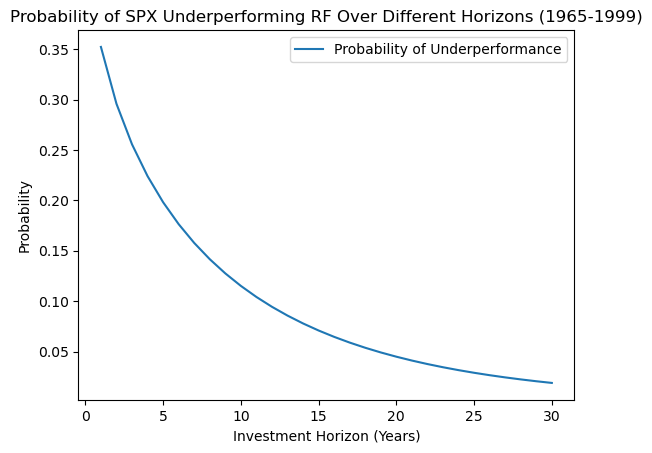

In [15]:
# 4.2
from scipy.stats import norm

def prob(mu, sigma, h):
    return norm.cdf(np.sqrt(h) * mu / sigma)

mu = summary_statistics.loc[('1965-1999', 'rm - rf (log)'), 'mean']  
sigma = summary_statistics.loc[('1965-1999', 'rm - rf (log)'), 'vol']

print(f'SPX underperforming RF in the next 15 years after 1999: {prob(mu=-mu, sigma=sigma, h=15):.2%}')
print(f'SPX underperforming RF in the next 30 years after 1999: {prob(mu=-mu, sigma=sigma, h=30):.2%}')

h = np.arange(1, 31)
probs = pd.DataFrame([prob(-mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index=h)

probs.plot(title="Probability of SPX Underperforming RF Over Different Horizons (1965-1999)", ylabel="Probability")
plt.xlabel("Investment Horizon (Years)")
plt.show()

SPX underperforming RF in the next 30 years after 2024: 1.91%


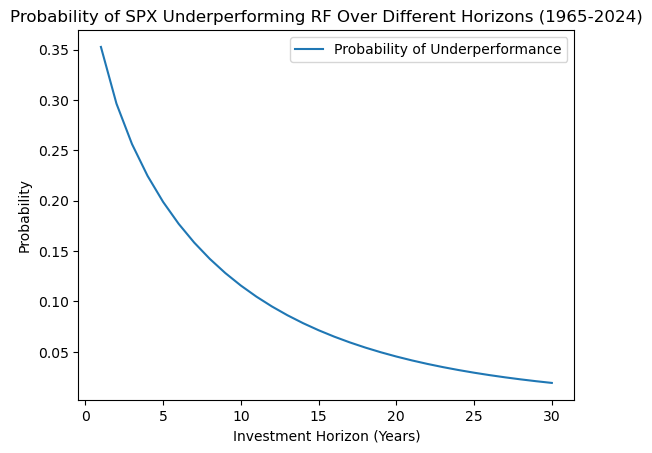

In [16]:
# 4.3
periods = [('1965', '2024')]
summary_statistics1 = calculate_univariate_performance_statistics(df_data, annualization_factor=12, periods=periods)
mu_1965_2024 = summary_statistics1.loc[('1965-2024', 'rm - rf (log)'), 'mean']  
sigma_1965_2024 = summary_statistics1.loc[('1965-2024', 'rm - rf (log)'), 'vol']

print(f'SPX underperforming RF in the next 30 years after 2024: {prob(mu=-mu_1965_2024, sigma=sigma_1965_2024, h=30):.2%}')
h = np.arange(1, 31)
probs = pd.DataFrame([prob(-mu_1965_2024, sigma_1965_2024, x) for x in h], columns=['Probability of Underperformance'], index=h)

probs.plot(title="Probability of SPX Underperforming RF Over Different Horizons (1965-2024)", ylabel="Probability")
plt.xlabel("Investment Horizon (Years)")
plt.show()

In [17]:
# 4.4

realized_mean_2000_2024 = summary_statistics.loc[('2000-2024', 'rm (log)'), 'mean']

mu_1965_1999 = summary_statistics.loc[('1965-1999', 'rm (log)'), 'mean']
sigma_1965_1999 = summary_statistics.loc[('1965-1999', 'rm (log)'), 'vol']

horizon = 25
z_score = (realized_mean_2000_2024 - mu_1965_1999) * np.sqrt(horizon) / sigma_1965_1999
probability = norm.cdf(z_score)

print(f"Probability that the 25-year market return (2000-2024) would be smaller than the realized return: {probability:.2%}")


Probability that the 25-year market return (2000-2024) would be smaller than the realized return: 7.85%
